In [24]:
# %load ../../../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_seq_items', None)
 
#%config InlineBackend.figure_formats = {'pdf',}
%matplotlib inline
 
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

# Anomaly Detection

In [2]:
data1 = loadmat('ex8data1.mat')

In [4]:
data1.keys()

['yval', '__header__', '__globals__', 'Xval', 'X', '__version__']

In [9]:
yval = data1['yval']
Xval = data1['Xval']
X = data1['X']
X.shape

(307, 2)

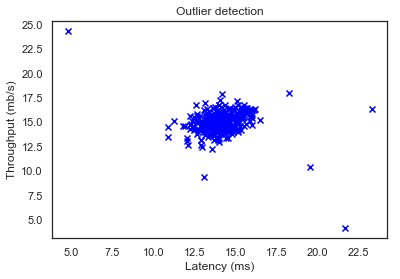

In [13]:
plt.scatter(X[:,0],X[:,1],c='b',marker ='x')
plt.title("Outlier detection")
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)');

## 1. 1 Gaussian distribution


1.1 Gaussian distribution
To perform anomaly detection, you will first need to fit a model to the data's distribution. Given a training set $\{x^{(1)}, \dots, x^{(m)} \}$ (where $x^{(i)} \in \mathbb{R}^n$ ), you want to estimate the Gaussian distribution for each of the features $x_i$ . For each feature $i = 1 \dots n$, you need to find parameters $\mu_i$ and $\sigma_i^2$ that fit the data in the $i^{th}$ dimension $\{ x_i^{(1)}, \dots, x_i^{(m)} \}$ (the $i^{th}$ dimension of each example).

The Gaussian distribution is given by

$$ p\left( x; \mu, \sigma^2 \right) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{\left(x-\mu\right)^2}{2\sigma^2}},$$
where $\mu$ is the mean and $\sigma^2$ is the variance.

### 1.2 Estimating parameters for a Gaussian


You can estimate the parameters $\left( \mu_i, \sigma_i^2 \right)$, of the $i^{th}$ feature by using the following equations. To estimate the mean, you will use:

$$ \mu_i = \frac{1}{m} \sum_{j=1}^m x_i^{(j)},$$
and for the variance you will use:

$$ \sigma_i^2 = \frac{1}{m} \sum_{j=1}^m \left( x_i^{(j)} - \mu_i \right)^2.$$
Your task is to complete the code in the function estimateGaussian. This function takes as input the data matrix X and should output an n-dimension vector mu that holds the mean for each of the $n$ features and another n-dimension vector sigma2 that holds the variances of each of the features. You can implement this using a for-loop over every feature and every training example (though a vectorized implementation might be more efficient; feel free to use a vectorized implementation if you prefer).

In [14]:
def estimateGaussian(X):
    """
    This function estimates the parameters of a Gaussian distribution
    using a provided dataset.
    
    Parameters
    ----------
    X : array_like
        The dataset of shape (m x n) with each n-dimensional 
        data point in one row, and each total of m data points.
    
    Returns
    -------
    mu : array_like 
        A vector of shape (n,) containing the means of each dimension.
    
    sigma2 : array_like
        A vector of shape (n,) containing the computed
        variances of each dimension.
    
    Instructions
    ------------
    Compute the mean of the data and the variances
    In particular, mu[i] should contain the mean of
    the data for the i-th feature and sigma2[i]
    should contain variance of the i-th feature.
    """
    # Useful variables
    m, n = X.shape

    # You should return these values correctly
    mu = np.zeros(n)
    sigma2 = np.zeros(n)

    # ====================== YOUR CODE HERE ======================
    mu = np.mean(X,axis = 0 )
    sigma2 = np.var(X,axis=0)
    
   # turn into n-rows vector
    mu = mu.T
    sigma2 = sigma2.T
    
    # =============================================================
    return mu, sigma2

### multivariate Gaussian

In [29]:
def multivariateGaussian(X, mu, Sigma2):
    """
    Computes the probability density function of the multivariate gaussian distribution.
    Parameters
    ----------
    X : array_like
        The dataset of shape (m x n). Where there are m examples of n-dimensions.
    mu : array_like
        A vector of shape (n,) contains the means for each dimension (feature).
    Sigma2 : array_like
        Either a vector of shape (n,) containing the variances of independent features
        (i.e. it is the diagonal of the correlation matrix), or the full
        correlation matrix of shape (n x n) which can represent dependent features.
    Returns
    ------
    p : array_like
        A vector of shape (m,) which contains the computed probabilities at each of the
        provided examples.
    """
    k = mu.size

    # if sigma is given as a diagonal, compute the matrix
    if Sigma2.ndim == 1:
        Sigma2 = np.diag(Sigma2)

    X = X - mu
    p = (2 * np.pi) ** (- k / 2) * np.linalg.det(Sigma2) ** (-0.5)\
        * np.exp(-0.5 * np.sum(np.dot(X, np.linalg.pinv(Sigma2)) * X, axis=1))
    return p

In [35]:
def visualizeFit(X, mu, sigma2):
    """
    Visualize the dataset and its estimated distribution.
    This visualization shows you the  probability density function of the Gaussian distribution.
    Each example has a location (x1, x2) that depends on its feature values.
    Parameters
    ----------
    X : array_like
        The dataset of shape (m x 2). Where there are m examples of 2-dimensions. We need at most
        2-D features to be able to visualize the distribution.
    mu : array_like
        A vector of shape (n,) contains the means for each dimension (feature).
    sigma2 : array_like
        Either a vector of shape (n,) containing the variances of independent features
        (i.e. it is the diagonal of the correlation matrix), or the full
        correlation matrix of shape (n x n) which can represent dependent features.
    """

    X1, X2 = np.meshgrid(np.arange(0, 35.5, 0.5), np.arange(0, 35.5, 0.5))
    Z = multivariateGaussian(np.stack([X1.ravel(), X2.ravel()], axis=1), mu, sigma2)
    Z = Z.reshape(X1.shape)

    plt.plot(X[:, 0], X[:, 1], 'bx', mec='b', mew=2, ms=8)

    if np.all(abs(Z) != np.inf):
        plt.contour(X1, X2, Z, levels=10**(np.arange(-20., 1, 3)), zorder=100)



array([14.11222578, 14.99771051])

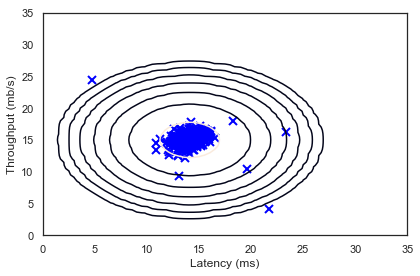

In [41]:
#  Estimate my and sigma2
mu, sigma2 = estimateGaussian(X)
p = multivariateGaussian(X, mu, sigma2)

visualizeFit(X,  mu, sigma2)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.tight_layout()


### 1.3 Selecting the threshold, 

1.3 Selecting the threshold, $\varepsilon$
Now that you have estimated the Gaussian parameters, you can investigate which examples have a very high probability given this distribution and which examples have a very low probability. The low probability examples are more likely to be the anomalies in our dataset. One way to determine which examples are anomalies is to select a threshold based on a cross validation set. In this part of the exercise, you will implement an algorithm to select the threshold $\varepsilon$ using the $F_1$ score on a cross validation set.

You should now complete the code for the function selectThreshold. For this, we will use a cross validation set $\{ (x_{cv}^{(1)}, y_{cv}^{(1)}), \dots, (x_{cv}^{(m_{cv})}, y_{cv}^{(m_{cv})})\}$, where the label $y = 1$ corresponds to an anomalous example, and $y = 0$ corresponds to a normal example. For each cross validation example, we will compute $p\left( x_{cv}^{(i)}\right)$. The vector of all of these probabilities $p\left( x_{cv}^{(1)}\right), \dots, p\left( x_{cv}^{(m_{cv})}\right)$ is passed to selectThreshold in the vector pval. The corresponding labels $y_{cv}^{(1)} , \dots , y_{cv}^{(m_{cv})}$ are passed to the same function in the vector yval.

The function selectThreshold should return two values; the first is the selected threshold $\varepsilon$. If an example $x$ has a low probability $p(x) &lt; \varepsilon$, then it is considered to be an anomaly. The function should also return the $F_1$ score, which tells you how well you are doing on finding the ground truth anomalies given a certain threshold. For many different values of $\varepsilon$, you will compute the resulting $F_1$ score by computing how many examples the current threshold classifies correctly and incorrectly.

The $F_1$ score is computed using precision ($prec$) and recall ($rec$):

$$ F_1 = \frac{2 \cdot prec \cdot rec}{prec + rec}, $$
You compute precision and recall by:

$$ prec = \frac{tp}{tp + fp}  $$
$$ rec = \frac{tp}{tp + fn} $$
where:

$tp$ is the number of true positives: the ground truth label says it’s an anomaly and our algorithm correctly classified it as an anomaly.

$fp$ is the number of false positives: the ground truth label says it’s not an anomaly, but our algorithm incorrectly classified it as an anomaly.

$fn$ is the number of false negatives: the ground truth label says it’s an anomaly, but our algorithm incorrectly classified it as not being anomalous.
In the provided code selectThreshold, there is already a loop that will try many different values of $\varepsilon$ and select the best $\varepsilon$ based on the $F_1$ score. You should now complete the code in selectThreshold. You can implement the computation of the $F_1$ score using a for-loop over all the cross validation examples (to compute the values $tp$, $fp$, $fn$). You should see a value for epsilon of about 8.99e-05.

In [39]:
def selectThreshold(yval, pval):
    """
    Find the best threshold (epsilon) to use for selecting outliers based
    on the results from a validation set and the ground truth.
    
    Parameters
    ----------
    yval : array_like
        The ground truth labels of shape (m, ).
    
    pval : array_like
        The precomputed vector of probabilities based on mu and sigma2 parameters. It's shape is also (m, ).
    
    Returns
    -------
    bestEpsilon : array_like
        A vector of shape (n,) corresponding to the threshold value.
    
    bestF1 : float
        The value for the best F1 score.
    
    Instructions
    ------------
    Compute the F1 score of choosing epsilon as the threshold and place the
    value in F1. The code at the end of the loop will compare the
    F1 score for this choice of epsilon and set it to be the best epsilon if
    it is better than the current choice of epsilon.
    
    Notes
    -----
    You can use predictions = (pval < epsilon) to get a binary vector
    of 0's and 1's of the outlier predictions
    """
    bestEpsilon = 0
    bestF1 = 0
    F1 = 0
   
    for epsilon in np.linspace(1.01*min(pval), max(pval), 1000):
        # ====================== YOUR CODE HERE =======================
        predictions = pval < epsilon
        
        # true positives is the intersection between 
        #   our positive predictions (cvPredictions==1) and positive ground truth values (yval==1)
        tp = np.sum(np.logical_and((predictions==1), (yval==1)).astype(float))# false positives are the ones we predicted to be true (cvPredictions==1) but weren't (yval==0)
        
        # false positives are the ones we predicted to be true (cvPredictions==1) but weren't (yval==0)
        fp = np.sum(np.logical_and((predictions ==1), (yval ==0)).astype(float))
        
        # false negatives are the ones we said were false (cvPredictions==0) but which were true (yval==1)
        fn = np.sum(np.logical_and((predictions==0),(yval==1)).astype(float))
        
       # compute precision, recall and F1
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        F1 = (2*precision*recall)/(precision+recall)
        
        # =============================================================
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon

    return bestEpsilon, bestF1

In [40]:
pval = multivariateGaussian(Xval, mu, sigma2)

epsilon, F1 = selectThreshold(yval, pval)
print('Best epsilon found using cross-validation: %.2e' % epsilon)
print('Best F1 on Cross Validation Set:  %f' % F1)
print('   (you should see a value epsilon of about 8.99e-05)')
print('   (you should see a Best F1 value of  0.875000)')

Best epsilon found using cross-validation: 8.99e-02
Best F1 on Cross Validation Set:  0.056957
   (you should see a value epsilon of about 8.99e-05)
   (you should see a Best F1 value of  0.875000)


# Recommender Systems

The next cell will load the dataset ex8_movies.mat, providing the variables Y and R. The matrix Y (a num_movies $\times$ num_users matrix) stores the ratings $y^{(i,j)}$ (from 1 to 5). The matrix R is an binary-valued indicator matrix, where $R(i, j) = 1$ if user $j$ gave a rating to movie $i$, and $R(i, j) = 0$ otherwise. The objective of collaborative filtering is to predict movie ratings for the movies that users have not yet rated, that is, the entries with $R(i, j) = 0$. This will allow us to recommend the movies with the highest predicted ratings to the user.

To help you understand the matrix Y, the following cell will compute the average movie rating for the first movie (Toy Story) and print its average rating.

In [44]:
data = loadmat('ex8_movies.mat')

In [45]:
data.keys()

['Y', 'R', '__version__', '__header__', '__globals__']

In [46]:
Y,R = data['Y'],data['R']

In [47]:
# From the matrix, we can compute statistics like average rating.
print('Average rating for movie 1 (Toy Story): %f / 5' %
      np.mean(Y[0, R[0, :] == 1]))

Average rating for movie 1 (Toy Story): 3.878319 / 5


Throughout this part of the exercise, you will also be working with the matrices, X and Theta:

$$ \text{X} = 
\begin{bmatrix}
- \left(x^{(1)}\right)^T - \\
- \left(x^{(2)}\right)^T - \\
\vdots \\
- \left(x^{(n_m)}\right)^T - \\
\end{bmatrix}, \quad
\text{Theta} = 
\begin{bmatrix}
- \left(\theta^{(1)}\right)^T - \\
- \left(\theta^{(2)}\right)^T - \\
\vdots \\
- \left(\theta^{(n_u)}\right)^T - \\
\end{bmatrix}.
$$
The $i^{th}$ row of X corresponds to the feature vector $x^{(i)}$ for the $i^{th}$ movie, and the $j^{th}$ row of Theta corresponds to one parameter vector $\theta^{(j)}$, for the $j^{th}$ user. Both $x^{(i)}$ and $\theta^{(j)}$ are n-dimensional vectors. For the purposes of this exercise, you will use $n = 100$, and therefore, $x^{(i)} \in \mathbb{R}^{100}$ and $\theta^{(j)} \in \mathbb{R}^{100}$. Correspondingly, X is a $n_m \times 100$ matrix and Theta is a $n_u \times 100$ matrix.

### 2.2 Collaborative filtering learning algorithm


Now, you will start implementing the collaborative filtering learning algorithm. You will start by implementing the cost function (without regularization).

The collaborative filtering algorithm in the setting of movie recommendations considers a set of n-dimensional parameter vectors $x^{(1)}, \dots, x^{(n_m)}$ and $\theta^{(1)} , \dots, \theta^{(n_u)}$, where the model predicts the rating for movie $i$ by user $j$ as $y^{(i,j)} = \left( \theta^{(j)} \right)^T x^{(i)}$. Given a dataset that consists of a set of ratings produced by some users on some movies, you wish to learn the parameter vectors $x^{(1)}, \dots, x^{(n_m)}, \theta^{(1)}, \dots, \theta^{(n_u)}$ that produce the best fit (minimizes the squared error).

You will complete the code in cofiCostFunc to compute the cost function and gradient for collaborative filtering. Note that the parameters to the function (i.e., the values that you are trying to learn) are X and Theta. In order to use an off-the-shelf minimizer such as scipy's minimize function, the cost function has been set up to unroll the parameters into a single vector called params. You had previously used the same vector unrolling method in the neural networks programming exercise.
The collaborative filtering cost function (without regularization) is given by

$$
J(x^{(1)}, \dots, x^{(n_m)}, \theta^{(1)}, \dots,\theta^{(n_u)}) = \frac{1}{2} \sum_{(i,j):r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right)^2
$$

### 2.2.2 Collaborative filtering gradient

2.2.2 Collaborative filtering gradient
Now you should implement the gradient (without regularization). Specifically, you should complete the code in cofiCostFunc to return the variables X_grad and Theta_grad. Note that X_grad should be a matrix of the same size as X and similarly, Theta_grad is a matrix of the same size as Theta. The gradients of the cost function is given by:

$$ \frac{\partial J}{\partial x_k^{(i)}} = \sum_{j:r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right) \theta_k^{(j)} $$$$ \frac{\partial J}{\partial \theta_k^{(j)}} = \sum_{i:r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)}- y^{(i,j)} \right) x_k^{(j)} $$
Note that the function returns the gradient for both sets of variables by unrolling them into a single vector. After you have completed the code to compute the gradients, the next cell run a gradient check (available in utils.checkCostFunction) to numerically check the implementation of your gradients (this is similar to the numerical check that you used in the neural networks exercise. If your implementation is correct, you should find that the analytical and numerical gradients match up closely.

**Implementation Note:** You can get full credit for this assignment without using a vectorized implementation, but your code will run much more slowly (a small number of hours), and so we recommend that you try to vectorize your implementation. To get started, you can implement the gradient with a for-loop over movies (for computing $\frac{\partial J}{\partial x^{(i)}_k}$) and a for-loop over users (for computing $\frac{\partial J}{\theta_k^{(j)}}$). When you first implement the gradient, you might start with an unvectorized version, by implementing another inner for-loop that computes each element in the summation. After you have completed the gradient computation this way, you should try to vectorize your implementation (vectorize the inner for-loops), so that you are left with only two for-loops (one for looping over movies to compute $\frac{\partial J}{\partial x_k^{(i)}}$ for each movie, and one for looping over users to compute $\frac{\partial J}{\partial \theta_k^{(j)}}$ for each user).
**Implementation Tip:** To perform the vectorization, you might find this helpful: You should come up with a way to compute all the derivatives associated with $x_1^{(i)} , x_2^{(i)}, \dots , x_n^{(i)}$ (i.e., the derivative terms associated with the feature vector $x^{(i)}$) at the same time. Let us define the derivatives for the feature vector of the $i^{th}$ movie as: $$ \left(X_{\text{grad}} \left(i, :\right)\right)^T = 
\begin{bmatrix}
\frac{\partial J}{\partial x_1^{(i)}} \\
\frac{\partial J}{\partial x_2^{(i)}} \\
\vdots \\
\frac{\partial J}{\partial x_n^{(i)}}
\end{bmatrix} = \quad
\sum_{j:r(i,j)=1} \left( \left( \theta^{(j)} \right)^T x^{(i)} - y^{(i,j)} \right) \theta^{(j)}
$$ To vectorize the above expression, you can start by indexing into `Theta` and `Y` to select only the elements of interests (that is, those with `r[i, j] = 1`). Intuitively, when you consider the features for the $i^{th}$ movie, you only need to be concerned about the users who had given ratings to the movie, and this allows you to remove all the other users from `Theta` and `Y`. 

Concretely, you can set `idx = np.where(R[i, :] == 1)[0]` to be a list of all the users that have rated movie $i$. This will allow you to create the temporary matrices `Theta_temp = Theta[idx, :]` and `Y_temp = Y[i, idx]` that index into `Theta` and `Y` to give you only the set of users which have rated the $i^{th}$ movie. This will allow you to write the derivatives as: 
`X_grad[i, :] = np.dot(np.dot(X[i, :], Theta_temp.T) - Y_temp, Theta_temp)` 

Note that the vectorized computation above returns a row-vector instead. After you have vectorized the computations of the derivatives with respect to $x^{(i)}$, you should use a similar method to vectorize the derivatives with respect to $θ^{(j)}$ as well.

In [56]:
def cofiCostFunc(params, Y, R, num_users, num_movies,
                      num_features, lambda_=0.0):
    """
    Collaborative filtering cost function.
    
    Parameters
    ----------
    params : array_like
        The parameters which will be optimized. This is a one
        dimensional vector of shape (num_movies x num_users, 1). It is the 
        concatenation of the feature vectors X and parameters Theta.
    
    Y : array_like
        A matrix of shape (num_movies x num_users) of user ratings of movies.
    
    R : array_like
        A (num_movies x num_users) matrix, where R[i, j] = 1 if the 
        i-th movie was rated by the j-th user.
    
    num_users : int
        Total number of users.
    
    num_movies : int
        Total number of movies.
    
    num_features : int
        Number of features to learn.
    
    lambda_ : float, optional
        The regularization coefficient.
    
    Returns
    -------
    J : float
        The value of the cost function at the given params.
    
    grad : array_like
        The gradient vector of the cost function at the given params.
        grad has a shape (num_movies x num_users, 1)
    
    Instructions
    ------------
    Compute the cost function and gradient for collaborative filtering.
    Concretely, you should first implement the cost function (without
    regularization) and make sure it is matches our costs. After that,
    you should implement thegradient and use the checkCostFunction routine 
    to check that the gradient is correct. Finally, you should implement
    regularization.
    
    Notes
    -----
    - The input params will be unraveled into the two matrices:
        X : (num_movies  x num_features) matrix of movie features
        Theta : (num_users  x num_features) matrix of user features

    - You should set the following variables correctly:

        X_grad : (num_movies x num_features) matrix, containing the 
                 partial derivatives w.r.t. to each element of X
        Theta_grad : (num_users x num_features) matrix, containing the 
                     partial derivatives w.r.t. to each element of Theta

    - The returned gradient will be the concatenation of the raveled 
      gradients X_grad and Theta_grad.
    """
    # Unfold the U and W matrices from params
    X = params[:num_movies*num_features].reshape(num_movies, num_features)
    Theta = params[num_movies*num_features:].reshape(num_users, num_features)

    # You need to return the following values correctly
    J = 0
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)

    # ====================== YOUR CODE HERE ======================
    squared_error = np.power(np.dot(X,Theta.T) - Y , 2)
    J = np.sum(squared_error * R)/2
    X_grad = np.dot((np.dot(X,Theta.T) - Y) * R , Theta)
    Theta_grad = np.dot(((np.dot(X,Theta.T) - Y) * R).T , X)
    
    # =============================================================
    
    grad = np.concatenate([X_grad.ravel(), Theta_grad.ravel()])
    return J, grad

In [59]:
#  Load pre-trained weights (X, Theta, num_users, num_movies, num_features)
data = loadmat(('ex8_movieParams.mat'))
X, Theta, num_users, num_movies, num_features = data['X'],\
        data['Theta'], data['num_users'], data['num_movies'], data['num_features']

#  Reduce the data set size so that this runs faster
num_users = 4
num_movies = 5
num_features = 3

X = X[:num_movies, :num_features]
Theta = Theta[:num_users, :num_features]
Y = Y[:num_movies, 0:num_users]
R = R[:num_movies, 0:num_users]

#  Evaluate cost function
J, _ = cofiCostFunc(np.concatenate([X.ravel(), Theta.ravel()]),
                    Y, R, num_users, num_movies, num_features)
           
print('Cost at loaded parameters:  %.2f \n(this value should be about 22.22)' % J)

Cost at loaded parameters:  22.22 
(this value should be about 22.22)


### Regularized cost function 

2.2.3 Regularized cost function
The cost function for collaborative filtering with regularization is given by

$$ J(x^{(1)}, \dots, x^{(n_m)}, \theta^{(1)}, \dots, \theta^{(n_u)}) = \frac{1}{2} \sum_{(i,j):r(i,j)=1} \left( \left( \theta^{(j)} \right)^T x^{(i)} - y^{(i,j)} \right)^2 + \left( \frac{\lambda}{2} \sum_{j=1}^{n_u} \sum_{k=1}^{n} \left( \theta_k^{(j)} \right)^2  \right) + \left( \frac{\lambda}{2} \sum_{i=1}^{n_m} \sum_{k=1}^n \left(x_k^{(i)} \right)^2 \right) $$
You should now add regularization to your original computations of the cost function, $J$. After you are done, the next cell will run your regularized cost function, and you should expect to see a cost of about 31.34.

In [ ]:
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lambda_var):
    #COFICOSTFUNC Collaborative filtering cost function
    #   [J, grad] = COFICOSTFUNC(params, Y, R, num_users, num_movies, ...
    #   num_features, lambda) returns the cost and gradient for the
    #   collaborative filtering problem.
    #

    # Unfold the U and W matrices from params
    X = np.reshape(params[:num_movies*num_features], (num_movies, num_features), order='F')
    Theta = np.reshape(params[num_movies*num_features:], (num_users, num_features), order='F')

    # You need to return the following values correctly
    J = 0
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)

    squared_error = np.power(np.dot(X,Theta.T) - Y,2)
    J = (1/2.) * np.sum(squared_error * R)

    X_grad = np.dot(( np.dot(X, Theta.T) - Y ) * R, Theta)
    Theta_grad = np.dot((( np.dot(X, Theta.T) - Y ) * R).T, X)

    ### COST FUNCTION WITH REGULARIZATION
    # only add regularized cost to J now
    J = J + (lambda_var/2.)*( np.sum( np.power(Theta, 2) ) + np.sum( np.power(X, 2) ) )

    ### GRADIENTS WITH REGULARIZATION
    # only add regularization terms
    X_grad = X_grad + lambda_var*X
    Theta_grad = Theta_grad + lambda_var*Theta

    # =============================================================

    grad = np.concatenate((X_grad.reshape(X_grad.size, order='F'), Theta_grad.reshape(Theta_grad.size, order='F')))

    return J, grad